# Background

Data science is a complex domain encompassing a broad range of tasks and workflows. While disparate in nature, general frameworks for implementing data science solutions have been devised. One of the most popular frameworks is the CRoss Industry Standard Platform for Data Mining (CRISP-DM). CRISP-DM is an interative approach and is outlined below.
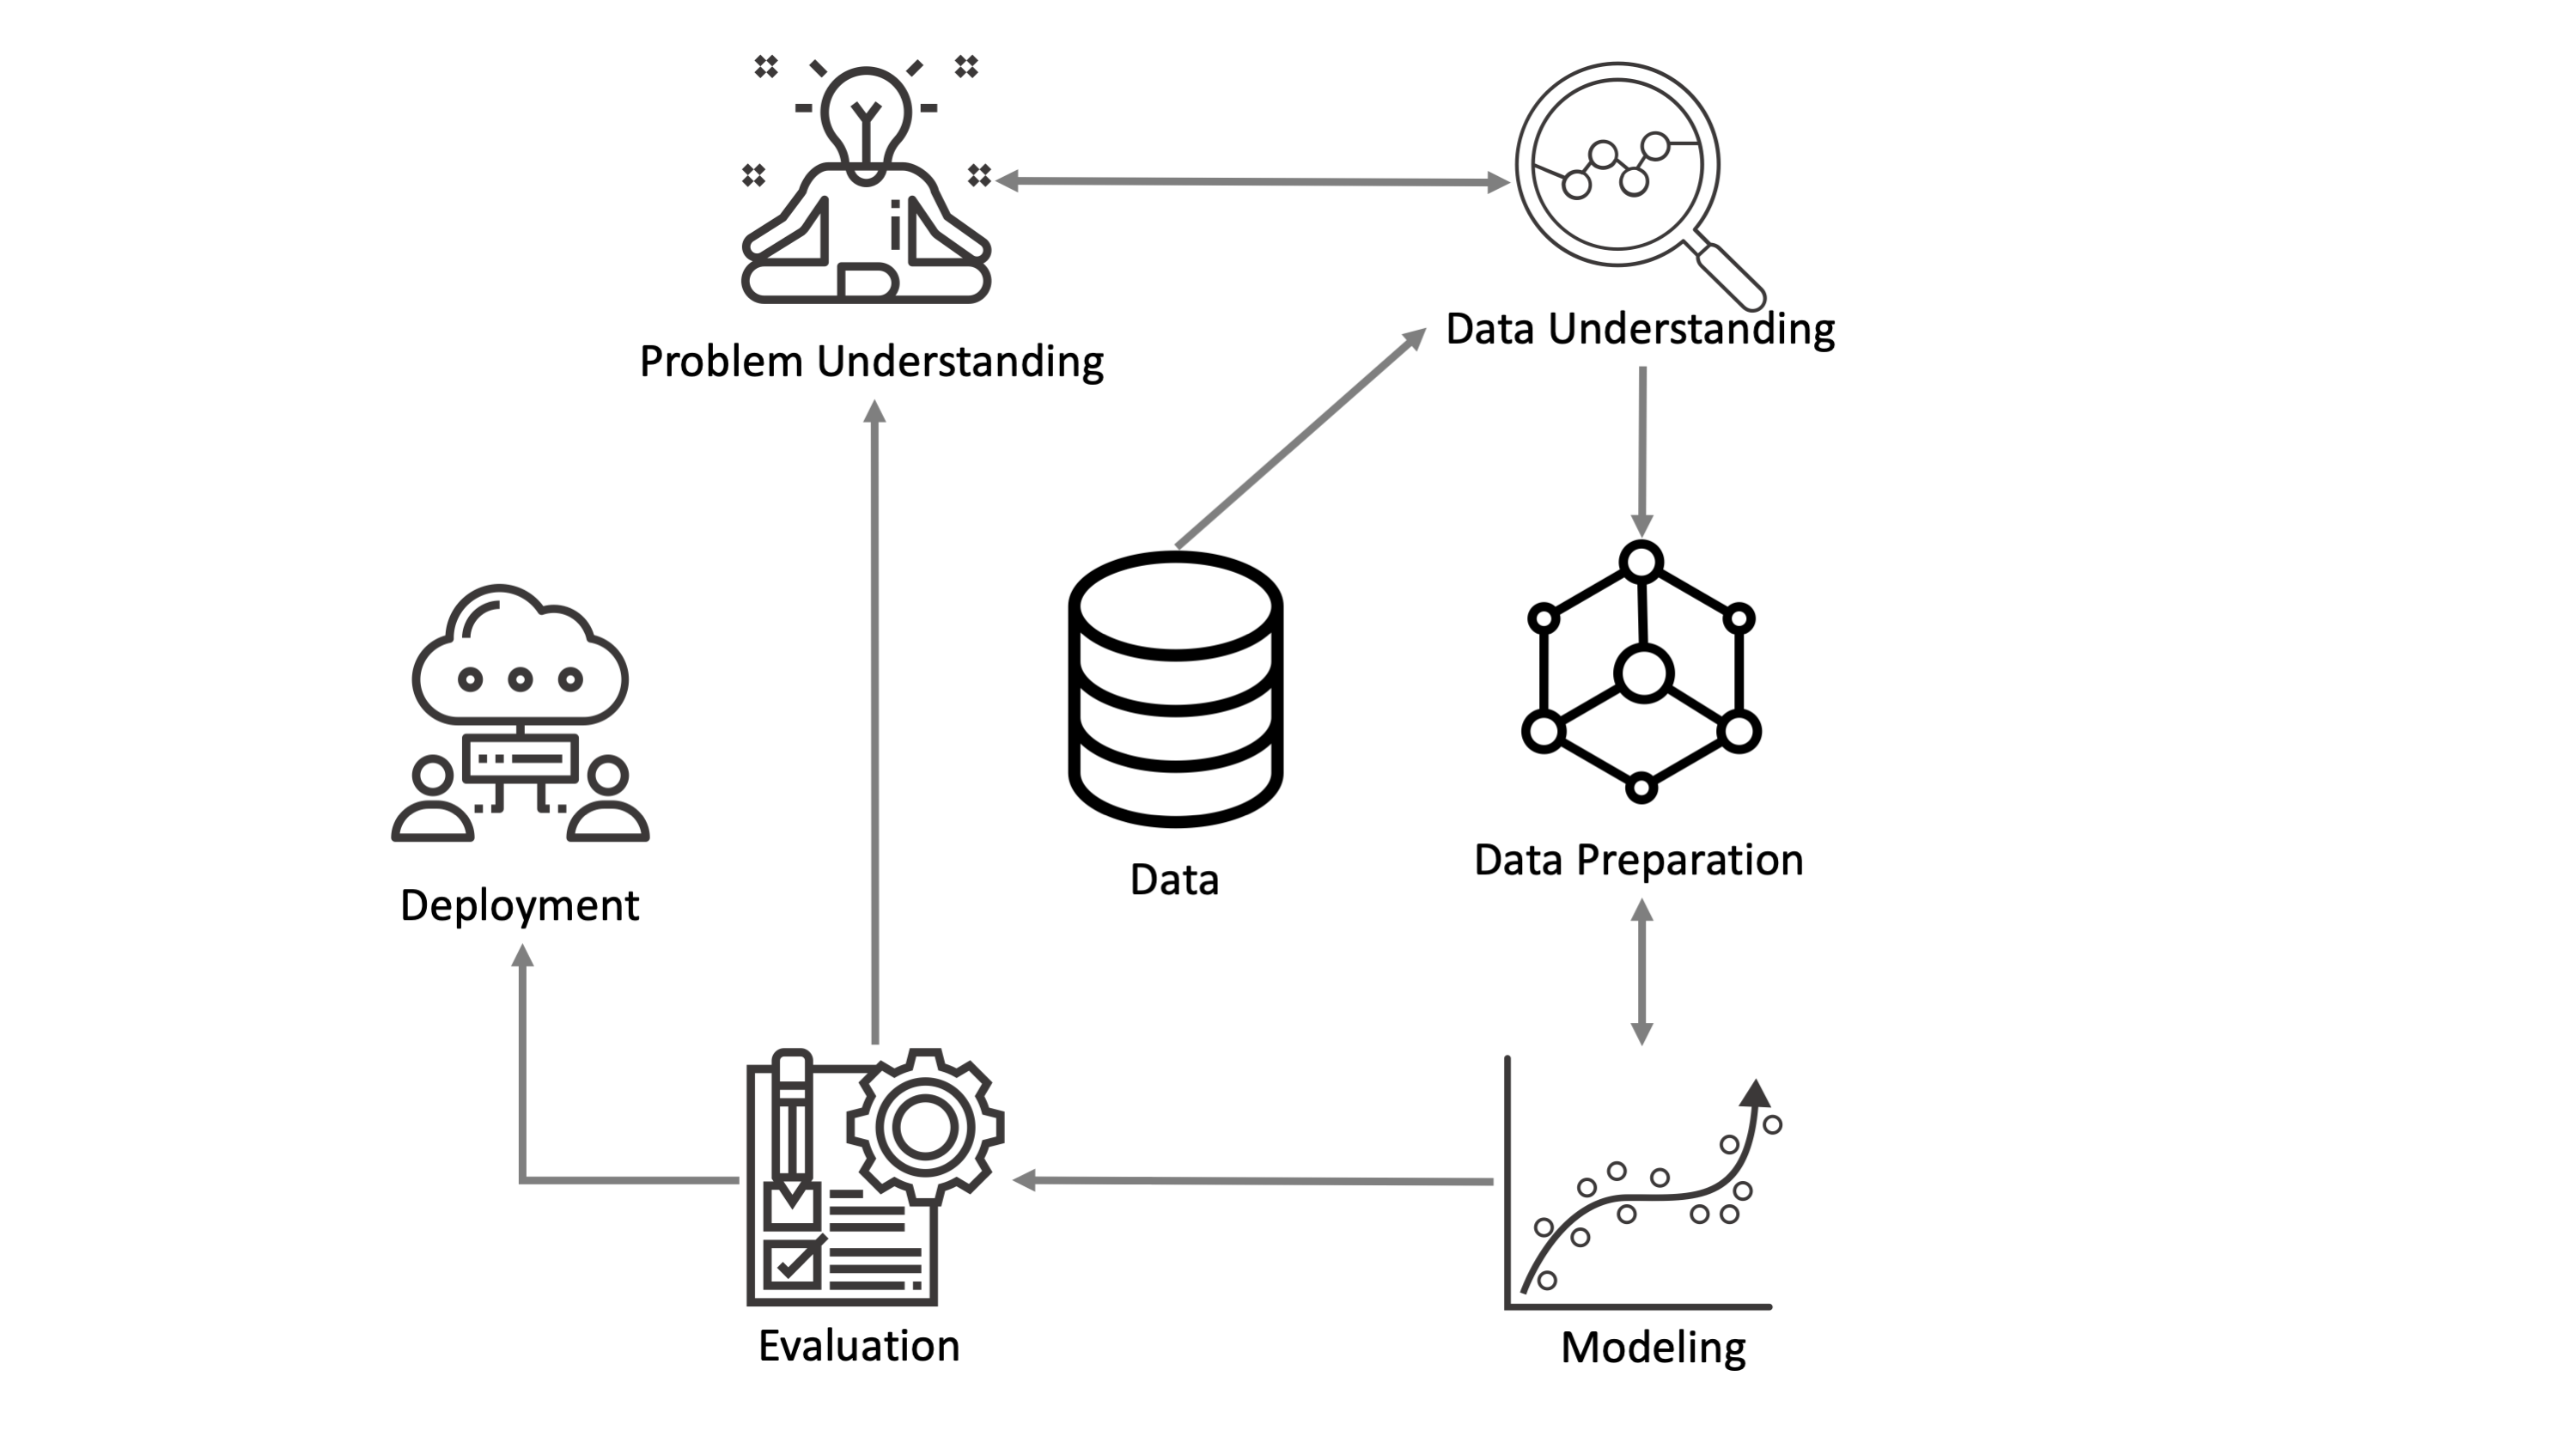

The process consists of the following 6 steps iterated over for the  duration of the cycle. 

### Problem Understanding

In this phase, data scientists collaborate with subject matter experts to understand the nature of the problem, the question(s) being asked, expected deliverables and intended use cases. The project is shaped in this phase and the data understanding phase and serves as a guidepost for the project going forward. 

### Data Understanding

Here, the data is analyzed by the data scientist in the context of the information gathered from the problem understanding phase. It is important to note that this phase is used to determine the feasbility of deliverables and goals derived from the problem understanding phase. The state of the data is used to reshape goals set in problem understanding and together these two phases shape the parameters of the project going forward. 

### Data Preparation

Using insights gleaned from data understanding, the data is converted from the form in which it is collected (often amenable to human consumption) to a form that facilitates good modeling performance and machine consumption. This phases includes steps such as encoding data, feature extraction and selection and handcrafting feaures. 

### Modeling

Here, prepared data is used to build machine learning models. This phases consists generally of two subphases. The first subphase is model selection. Here a wide variety of models are tested and run for short periods of time to ascertain performance. *A priori* we do not know which model will produce the best performance, so a brute force testing approach is often used. Once initial performance is assessed, we move to the second subphase. Here, we downselect one (or several) models for optimization (hyperparameter tuning). This is a more expensive process, so using fewer models for this saves both time and money.  

### Evaluation

In this phase, top-performing models from the previous phase are evaluated more expansively for performance. This is done using a test (holdout) set that was set aside from the training dataset. The goal here is twofold. 1) To assess generalizability of the model - i.e. how well it will perform on data that it has not been trained on. This provides us with a sense of how well the model will perform in deployment. 2) How well does the model meet the intended use cases and goals derived from the first two phases of the project. This is domain specific and varies between projects. Aim 2 is often done in conjunction with subject matter experts. 

### Deployment

The final phase of each iteration, the model is deployed for use and tested on data prospectively. The model is further evaluated in this step (and sometimes multiple models are deployed) and calibration of the model can occur to further improve performance. This represents the step with the highest failure rate, since model generalizability is challengin to measure, and effects like data drift result in model performance degradation over time. 

In [1]:
import pandas as pd
import os
from ydata_profiling import ProfileReport
import sys

/home/parallels/anaconda3/envs/py310_datascience/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/home/parallels/anaconda3/envs/py310_datascience/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


In [2]:
os_platform = sys.platform

if os_platform == 'windows':
    RootDir = '\\'.join(os.getcwd().split('\\')[0:-2])
else:
    RootDir = '/'.join(os.getcwd().split('/')[0:-2])
os.chdir(RootDir)

# Determine the cohort

## Read in the data 

We can use pandas to read in the data for each of the three tables we will need.

In [3]:
# Read in the patient and icu data
icu_df = pd.read_csv('data/icustay.csv.gz',compression='gzip')
patient_df = pd.read_csv('data/patients.csv.gz',compression='gzip')
admission_df = pd.read_csv('data/admissions.csv.gz',compression='gzip')

## Join the data by subject

As often happens, we have multiple pertinent data stored in different tables that need to be combined together. To do this, we have two available commands, merge and join. Join will combine dataframes based on index, whereas merge will combine based on column values. Because we have unique subject ids and icu admission ids and there are no clear ordered indices, we will use merge. 

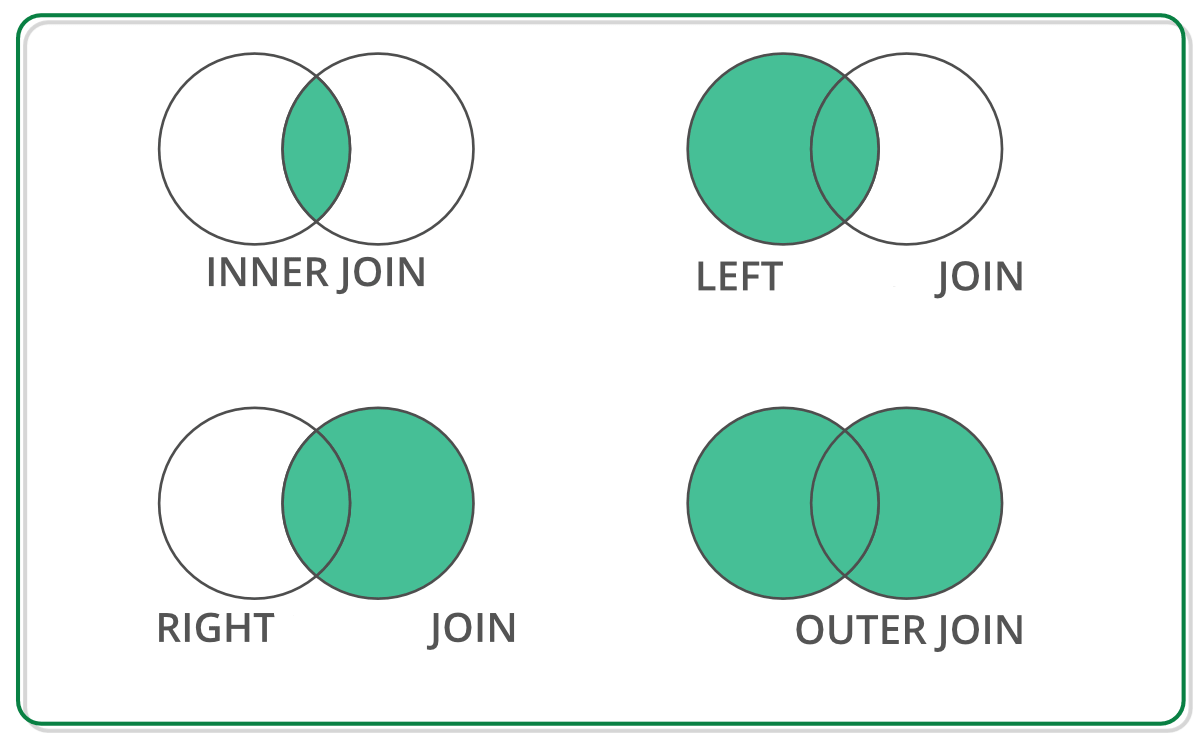

In [4]:
# Here, we merge the patient information table on the admission information, so we can determine the admission information for each patient
merge_df = pd.merge(patient_df, admission_df, on='subject_id')
merge_df[['subject_id','hadm_id','admittime','dischtime']]

subject_id  hadm_id                admittime                dischtime
0             249   116935  2149-12-17 20:41:00.000  2149-12-31 14:55:00.000
1             249   149546  2155-02-03 20:16:00.000  2155-02-14 11:15:00.000
2             249   158975  2156-04-27 15:33:00.000  2156-05-14 15:30:00.000
3             250   124271  2188-11-12 09:22:00.000  2188-11-22 12:00:00.000
4             251   117937  2110-07-27 06:46:00.000  2110-07-29 15:23:00.000
...           ...      ...                      ...                      ...
58971       44089   165748  2111-09-30 12:04:00.000  2111-10-03 16:04:00.000
58972       44115   163623  2161-07-15 12:00:00.000  2161-07-19 12:30:00.000
58973       44123   116395  2135-01-06 07:15:00.000  2135-01-12 02:50:00.000
58974       44126   183530  2129-01-03 07:15:00.000  2129-01-11 12:29:00.000
58975       44128   141304  2149-06-08 15:21:00.000  2149-06-23 18:44:00.000

[58976 rows x 4 columns]

## Join the icu data on admission

In [5]:
# Now, we will merge the previous table with the icu table. This will provide us wih patient information for each icu stay.
nicu_df = pd.merge(merge_df, icu_df, on='hadm_id')
nicu_df = nicu_df[nicu_df['first_careunit']=='NICU'].reset_index(drop=True)

In [6]:
# Here we convert the times to datetime and sort by subject id and time in.
nicu_df['intime'] = nicu_df['intime'].astype('datetime64[ns]')
nicu_df['outtime'] = nicu_df['outtime'].astype('datetime64[ns]')
nicu_df = nicu_df.sort_values(['subject_id_x','intime'])
nicu_df.reset_index(inplace=True, drop=True)

### Operations on Pandas Dataframes

We need to determine whether our patient has been readmited within 7 days to the NICU. To do this, we must first groupby the patient and then calculate the difference between the intime for admision n+1 and the discharge time for admission n. This can be done by combining three separate operations, apply, groupby and shift. Groupby groups the (previously sorted) rows into those with the same patient id. We then apply the function to these groups only. This is performed on the previous row's outtime (accessed via the shift command) and the current intime. We calculate the difference using a user defined function and passing the contents of each row using the lamda operator. Finally, we set the resulting timedelta to a new row in the previous dataset. 

In [7]:
def f_diff(t0, t1):
    return t1 - t0

t_df = nicu_df.groupby('subject_id_x').apply(lambda x: f_diff(x.outtime.shift(), x.intime)).reset_index(drop=True)

In [8]:
nicu_df['time_elapsed_from_discharge'] = t_df
nicu_df

row_id_x  subject_id_x gender                      dob  dod dod_hosp  \
0            1             2      M  2138-07-17 00:00:00.000  NaN      NaN   
1            4             5      M  2103-02-02 00:00:00.000  NaN      NaN   
2            6             7      F  2121-05-23 00:00:00.000  NaN      NaN   
3            6             7      F  2121-05-23 00:00:00.000  NaN      NaN   
4            7             8      M  2117-11-20 00:00:00.000  NaN      NaN   
...        ...           ...    ...                      ...  ...      ...   
8095     30790         32799      M  2164-02-16 00:00:00.000  NaN      NaN   
8096     30792         32801      M  2191-04-07 00:00:00.000  NaN      NaN   
8097     30793         32802      F  2126-01-28 00:00:00.000  NaN      NaN   
8098     30794         32803      F  2118-02-06 00:00:00.000  NaN      NaN   
8099     30797         32806      M  2162-10-22 00:00:00.000  NaN      NaN   

     dod_ssn  expire_flag  row_id_y  hadm_id  ... icustay_id dbsource  \
0        NaN            0         1   163353  ...     243653  carevue   
1        NaN            0         4   178980  ...     214757  carevue   
2        NaN            0         6   118037  ...     278444  carevue   
3        NaN            0         6   118037  ...     236754  carevue   
4        NaN            0         7   159514  ...     262299  carevue   
...      ...          ...       ...      ...  ...        ...      ...   
8095     NaN            0     39768   116323  ...     266004  carevue   
8096     NaN            0     39770   158613  ...     248765  carevue   
8097     NaN            0     39771   128876  ...     254901  carevue   
8098     NaN            0     39772   105824  ...     229957  carevue   
8099     NaN            0     39777   104049  ...     262007  carevue   

     first_careunit last_careunit first_wardid last_wardid  \
0              NICU          NICU           56          56   
1              NICU          NICU           56          56   
2              NICU          NICU           56          56   
3              NICU          NICU           56          56   
4              NICU          NICU           56          56   
...             ...           ...          ...         ...   
8095           NICU          NICU           56          56   
8096           NICU          NICU           56          56   
8097           NICU          NICU           56          56   
8098           NICU          NICU           56          56   
8099           NICU          NICU           56          56   

                  intime             outtime       los  \
0    2138-07-17 21:20:07 2138-07-17 23:32:21    0.0918   
1    2103-02-02 06:04:24 2103-02-02 08:06:00    0.0844   
2    2121-05-23 15:35:29 2121-05-23 22:01:00    0.2677   
3    2121-05-25 03:26:01 2121-05-25 21:10:19    0.7391   
4    2117-11-20 12:36:10 2117-11-21 14:24:55    1.0755   
...                  ...                 ...       ...   
8095 2164-02-16 22:29:27 2164-02-17 03:40:14    0.2158   
8096 2191-04-07 16:50:07 2191-04-08 00:17:01    0.3103   
8097 2126-01-28 07:02:06 2126-01-28 11:34:52    0.1894   
8098 2118-02-06 17:36:42 2118-06-25 17:26:18  138.9928   
8099 2162-10-22 03:03:36 2162-11-03 15:32:17   12.5199   

     time_elapsed_from_discharge  
0                            NaT  
1                            NaT  
2                            NaT  
3                1 days 05:25:01  
4                            NaT  
...                          ...  
8095                         NaT  
8096                         NaT  
8097                         NaT  
8098                         NaT  
8099                         NaT  

[8100 rows x 38 columns]

30,000 foot view: we care determining who is a readmission

Now that we have calculated the time difference between each row's intime and the previous outtime, we have to determine if they have been admitted within 7 days or not and set a target flag accordingly. We do this by first identifying the index of all rows that match this criteria. Because we want to identify whether a patient has been readmitted prior to discharge, the actual flag needs to be set for the previous row. This can again be performed using the shift function. We then set a new column name that defaults to 0 (no readmission) and then set all identified indices to 1 (yes readmission). 

In [9]:
indx = nicu_df.index[nicu_df['time_elapsed_from_discharge'].shift(-1) < pd.to_timedelta(8,'D')].tolist()
nicu_df['readmit_flag'] = 0
nicu_df.loc[indx,'readmit_flag'] = 1
nicu_df['readmit_flag'].value_counts()

readmit_flag
0    7911
1     189
Name: count, dtype: int64

In [10]:
# Finally remove redundant columns and rename existing ones
nicu_df = nicu_df.drop(columns=['subject_id_y','row_id']).rename(columns={'row_id_x':'row_id','subject_id_x':'subject_id'})

## Feature Engineering

Now that we have the core dataset, containing patient information and target flags for the cohort of interest, let's try creating some aditional clinical features that we might find useful. We can engineer many different features for the model to ingest. However, several important features from literature (and experience) are: 1) The presence of a microorganism from lab tests, 2) Fraction of lab measurements labeled as abnormal, 3) Number of total diagnoses (measure of medical complexity), 4) Total number of prescriptions (medical complexity), 5) presence of certain interesting ICD codes. Below we can engineer these features step by step.

## Get the Microbiology data

Now we can include important features from the microbiology features. In particular, we would like to determine if a patient has been identified with an infection. This can be determined usind the interpretation column, which interprets the result of the test. In this case, we consider any interpretation of a microorganism to be a positive flag, and do no distringuish between bacterial resistant and not. We also interpret a NaN value as not resistant (or more accurately, no evidence for resistance).

In [11]:
# Micro 
micro_df = pd.read_csv('data/microbiologyevents.csv.gz',compression='gzip')
micro_df['micro_organism'] = micro_df['interpretation'].fillna(0)
micro_df.loc[micro_df['micro_organism']!=0, 'micro_organism'] = 1
micro_df_group = micro_df.groupby(['subject_id','hadm_id']).agg({'micro_organism':'max'})
micro_df_group.reset_index(inplace=True)
micro_df_group['micro_organism'].value_counts()
micro_df_group

subject_id  hadm_id micro_organism
0              2   163353              0
1              5   178980              0
2              7   118037              0
3              8   159514              0
4             10   184167              0
...          ...      ...            ...
6748       32799   116323              0
6749       32801   158613              0
6750       32802   128876              0
6751       32803   105824              1
6752       32806   104049              0

[6753 rows x 3 columns]

## Get Fraction of abnormal lab events

Now we can determine the fraction of all labs flagged as abnormal. This can be done by setting all abnormal flags to 1 and then summing them (to get the total count of abnormal flags). We can then count all labs for a patient. The fraction of the sum / count corresponds to the fraction of labs that are abnormal. This approach has an inherent advantage that the data is naturally bound between 0 - 1, which helps make the feature more robust. As an example, 10/10 and 100/100 are treated the same, which prevents the feature from exceeding the bounds that the model has been trained on. 

In [12]:
lab_df = pd.read_csv('data/labevents.csv.gz',compression='gzip')
lab_df['abnormal_flag'] = lab_df['flag'].fillna(0)
lab_df.loc[(lab_df['abnormal_flag']=='abnormal')|(lab_df['abnormal_flag']=='delta'), 'abnormal_flag'] = 1
lab_df_group = lab_df.groupby(['subject_id','hadm_id']).agg({'abnormal_flag':['sum','count']}).reset_index()
lab_df_group.columns = lab_df_group.columns.map('_'.join)
lab_df_group['abnormal_lab_fraction'] = lab_df_group['abnormal_flag_sum'] /  lab_df_group['abnormal_flag_count']
lab_df_group = lab_df_group.rename(columns={'subject_id_':'subject_id','hadm_id_':'hadm_id'})
lab_df_group.reset_index(inplace=True)
lab_df_group

index  subject_id  hadm_id abnormal_flag_sum  abnormal_flag_count  \
0         0           2   163353                16                   47   
1         1           5   178980                 5                   19   
2         2           7   118037                20                   56   
3         3           8   159514                14                   35   
4         4          10   184167                 9                   52   
...     ...         ...      ...               ...                  ...   
7754   7754       32799   116323                10                   25   
7755   7755       32801   158613                10                   36   
7756   7756       32802   128876                 8                   32   
7757   7757       32803   105824               488                 1327   
7758   7758       32806   104049                26                   76   

     abnormal_lab_fraction  
0                 0.340426  
1                 0.263158  
2                 0.357143  
3                      0.4  
4                 0.173077  
...                    ...  
7754                   0.4  
7755              0.277778  
7756                  0.25  
7757              0.367747  
7758              0.342105  

[7759 rows x 6 columns]

## Diagnosis Data

Each diagnosis is entered as a separate row, meaning that each patient and admission has multiple rows associated with it. Additionally, each patient can have different diagnoses, meaning that each unique diagnosis should be converted into a binary column. This can be done using one-hot encoding in scikit-learn, or the convenient get_dummies function in pandas. Here, we convert the ICD-9 codes to binary columns indicating whether the code is present or not. We can then sum across each row to calculate the total number of diagnoses. Additionally, we can incorporate specific diagnoses of interest as input features. 

In [13]:
diagnoses_df = pd.read_csv('data/diagnoses.csv.gz',compression='gzip')

In [14]:
ProfileReport(diagnoses_df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
diagnoses_df_group = pd.get_dummies(diagnoses_df, columns=['icd9_code']).groupby(['subject_id','hadm_id'], as_index=False).max()
diagnoses_df_group[diagnoses_df_group.columns[4:]] = diagnoses_df_group[diagnoses_df_group.columns[4:]].astype('int')
diagnoses_df_group['total_dx']  = diagnoses_df_group[diagnoses_df_group.columns[4:]].sum(axis=1)
diagnoses_df_group

/tmp/ipykernel_15762/672370996.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  diagnoses_df_group['total_dx']  = diagnoses_df_group[diagnoses_df_group.columns[4:]].sum(axis=1)


subject_id  hadm_id  row_id  seq_num  icd9_code_0088  icd9_code_0380  \
0              2   163353       3        3               0               0   
1              5   178980      24        3               0               0   
2              7   118037      35        3               0               0   
3              8   159514      41        6               0               0   
4             10   184167      52        5               0               0   
...          ...      ...     ...      ...             ...             ...   
7987       32799   116323  378975        1               0               0   
7988       32801   158613  378990        4               0               0   
7989       32802   128876  378993        3               0               0   
7990       32803   105824  379016       23               0               0   
7991       32806   104049  379112        7               0               0   

      icd9_code_03810  icd9_code_03811  icd9_code_03819  icd9_code_03840  ...  \
0                   0                0                0                0  ...   
1                   0                0                0                0  ...   
2                   0                0                0                0  ...   
3                   0                0                0                0  ...   
4                   0                0                0                0  ...   
...               ...              ...              ...              ...  ...   
7987                0                0                0                0  ...   
7988                0                0                0                0  ...   
7989                0                0                0                0  ...   
7990                0                0                0                0  ...   
7991                0                0                0                0  ...   

      icd9_code_V640  icd9_code_V6405  icd9_code_V643  icd9_code_V660  \
0                  0                0               0               0   
1                  0                0               0               0   
2                  0                0               0               0   
3                  0                0               0               0   
4                  0                0               0               0   
...              ...              ...             ...             ...   
7987               0                0               0               0   
7988               0                0               0               0   
7989               0                0               0               0   
7990               0                0               0               0   
7991               0                0               0               0   

      icd9_code_V667  icd9_code_V707  icd9_code_V721  icd9_code_V7219  \
0                  0               0               0                0   
1                  0               0               0                0   
2                  0               0               0                0   
3                  0               0               0                0   
4                  0               0               0                0   
...              ...             ...             ...              ...   
7987               0               0               0                0   
7988               0               0               0                0   
7989               0               0               0                0   
7990               0               0               0                0   
7991               0               0               0                0   

      icd9_code_V8381  total_dx  
0                   0         3  
1                   0         3  
2                   0         3  
3                   0         6  
4                   0         5  
...               ...       ...  
7987                0         1  
7988                0         4  
7989                0         3  
79

## Prescription Data

Much like the diagnosis data, each prescription is entered as a row, and these can be converted into binary columns. Using the same approach, we generate unique columns for the NDC codes provided and then sum across each row to determine the total number of prescriptions. 

In [16]:
prescriptions_df = pd.read_csv('data/prescriptions.csv.gz',compression='gzip')
prescriptions_df = prescriptions_df[prescriptions_df['drug_type']=='MAIN']
prescriptions_df = prescriptions_df[['subject_id','hadm_id','ndc']]
prescriptions_df_group = pd.get_dummies(prescriptions_df, columns=['ndc']).groupby(['subject_id','hadm_id'], as_index=False).max()
prescriptions_df_group[prescriptions_df_group.columns[2:]] = prescriptions_df_group[prescriptions_df_group.columns[2:]].astype('int')
prescriptions_df_group['total_rx']  = prescriptions_df_group[prescriptions_df_group.columns[2:]].sum(axis=1)
prescriptions_df_group

/tmp/ipykernel_15762/430065296.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  prescriptions_df_group['total_rx']  = prescriptions_df_group[prescriptions_df_group.columns[2:]].sum(axis=1)


subject_id  hadm_id  ndc_0.0  ndc_2050101.0  ndc_2717510.0  \
0              2   163353        0              0              0   
1              8   159514        0              0              0   
2             10   184167        1              0              0   
3             27   134931        0              0              0   
4             50   132761        0              0              0   
...          ...      ...      ...            ...            ...   
3714       32784   131855        0              0              0   
3715       32795   128974        0              0              0   
3716       32801   158613        0              0              0   
3717       32803   105824        1              0              0   
3718       32806   104049        0              0              0   

      ndc_2726601.0  ndc_2821501.0  ndc_3043730.0  ndc_3063441.0  \
0                 0              0              0              0   
1                 0              0              0              0   
2                 0              0              0              0   
3                 0              0              0              0   
4                 0              0              0              0   
...             ...            ...            ...            ...   
3714              0              0              0              0   
3715              0              0              0              0   
3716              0              0              0              0   
3717              0              0              0              0   
3718              0              0              0              0   

      ndc_3173840.0  ...  ndc_67386051151.0  ndc_67386071155.0  \
0                 0  ...                  0                  0   
1                 0  ...                  0                  0   
2                 0  ...                  0                  0   
3                 0  ...                  0                  0   
4                 0  ...                  0                  0   
...             ...  ...                ...                ...   
3714              0  ...                  0                  0   
3715              0  ...                  0                  0   
3716              0  ...                  0                  0   
3717              0  ...                  1                  1   
3718              0  ...                  0                  0   

      ndc_67425000210.0  ndc_68094021462.0  ndc_68135045502.0  \
0                     0                  0                  0   
1                     0                  0                  0   
2                     0                  0                  0   
3                     0                  0                  0   
4                     0                  0                  0   
...                 ...                ...                ...   
3714                  0                  0                  0   
3715                  0                  0                  0   
3716                  0                  0                  0   
3717                  0                  0                  0   
3718                  0                  0                  0   

      ndc_68180020203.0  ndc_72140003147.0  ndc_74300000068.0  \
0                     0                  0                  0   
1                     0                  0                  0   
2                     0                  0                  0   
3                     0                  0                  0   
4                     0                  0                  0   
...                 ...                ...                ...   
3714                  0                  0                  0   
3715                  0                  0                  0   
3716                  0                  0                  0   
3717                  0                  0                  0   
3718                  0                  0                  0   

      ndc_7430000

## Join everything together

Now that we have all of the tables of interest, we can join them together using the admisison id. 

In [17]:
# Merge everything
merge_df = pd.merge(nicu_df,diagnoses_df_group,on='hadm_id',how='left')
merge_df.drop(columns=['subject_id_y','row_id_y']).rename(columns={'row_id_x':'row_id','subject_id_x':'subject_id'})

merge_df = pd.merge(merge_df,prescriptions_df_group,on='hadm_id',how='left')
merge_df = merge_df.drop(columns=['subject_id_y','row_id_y']).rename(columns={'row_id_x':'row_id','subject_id_x':'subject_id'})

merge_df = pd.merge(merge_df,micro_df_group,on='hadm_id',how='left')
merge_df = merge_df.drop(columns=['subject_id_y','row_id']).rename(columns={'row_id_x':'row_id','subject_id_x':'subject_id'})

merge_df = pd.merge(merge_df,lab_df_group,on='hadm_id',how='left')
merge_df = merge_df.drop(columns=['subject_id_y','index']).rename(columns={'row_id_x':'row_id','subject_id_x':'subject_id'})

In [18]:
# Print out the pandas dataframe
merge_df

subject_id gender                      dob  dod dod_hosp dod_ssn  \
0              2      M  2138-07-17 00:00:00.000  NaN      NaN     NaN   
1              5      M  2103-02-02 00:00:00.000  NaN      NaN     NaN   
2              7      F  2121-05-23 00:00:00.000  NaN      NaN     NaN   
3              7      F  2121-05-23 00:00:00.000  NaN      NaN     NaN   
4              8      M  2117-11-20 00:00:00.000  NaN      NaN     NaN   
...          ...    ...                      ...  ...      ...     ...   
8095       32799      M  2164-02-16 00:00:00.000  NaN      NaN     NaN   
8096       32801      M  2191-04-07 00:00:00.000  NaN      NaN     NaN   
8097       32802      F  2126-01-28 00:00:00.000  NaN      NaN     NaN   
8098       32803      F  2118-02-06 00:00:00.000  NaN      NaN     NaN   
8099       32806      M  2162-10-22 00:00:00.000  NaN      NaN     NaN   

      expire_flag  hadm_id                admittime                dischtime  \
0               0   163353  2138-07-17 19:04:00.000  2138-07-21 15:48:00.000   
1               0   178980  2103-02-02 04:31:00.000  2103-02-04 12:15:00.000   
2               0   118037  2121-05-23 15:05:00.000  2121-05-27 11:57:00.000   
3               0   118037  2121-05-23 15:05:00.000  2121-05-27 11:57:00.000   
4               0   159514  2117-11-20 10:22:00.000  2117-11-24 14:20:00.000   
...           ...      ...                      ...                      ...   
8095            0   116323  2164-02-16 20:33:00.000  2164-02-19 15:30:00.000   
8096            0   158613  2191-04-07 16:08:00.000  2191-04-08 22:55:00.000   
8097            0   128876  2126-01-28 06:51:00.000  2126-01-30 15:05:00.000   
8098            0   105824  2118-02-06 17:14:00.000  2118-06-25 15:00:00.000   
8099            0   104049  2162-10-22 03:00:00.000  2162-11-03 13:50:00.000   

      ... ndc_68135045502.0 ndc_68180020203.0 ndc_72140003147.0  \
0     ...               0.0               0.0               0.0   
1     ...               NaN               NaN               NaN   
2     ...               NaN               NaN               NaN   
3     ...               NaN               NaN               NaN   
4     ...               0.0               0.0               0.0   
...   ...               ...               ...               ...   
8095  ...               NaN               NaN               NaN   
8096  ...               0.0               0.0               0.0   
8097  ...               NaN               NaN               NaN   
8098  ...               0.0               0.0               0.0   
8099  ...               0.0               0.0               0.0   

     ndc_74300000068.0 ndc_74300000300.0 total_rx micro_organism  \
0                  0.0               0.0      2.0              0   
1                  NaN               NaN      NaN              0   
2                  NaN               NaN      NaN              0   
3                  NaN               NaN      NaN              0   
4                  0.0               0.0      2.0              0   
...                ...               ...      ...            ...   
8095               NaN               NaN      NaN              0   
8096               0.0               0.0      2.0              0   
8097               NaN               NaN      NaN              0   
8098               0.0               0.0     43.0              1   
8099               0.0               0.0      5.0              0   

     abnormal_flag_sum abnormal_flag_count abnormal_lab_fraction  
0                   16                47.0              0.340426  
1                    5                19.0              0.263158  
2                   20                56.0              0.357143  
3                   20                56.0              0.357143  
4                   14                35.0                   0.4  
...                ...                 ...                   ...  
8095                10                25.0                   0.4 

In [19]:
# Specific feature list to use. 
feature_list = [
    'gender',
    'admission_type',
    'insurance',
    'ethnicity',
    'diagnosis',
    'total_rx',
    'total_dx',
    'los',
    'abnormal_lab_fraction',
    'micro_organism',
    'icd9_code_V053',
    'icd9_code_V290',
    'icd9_code_7742',
    'icd9_code_769',
    'readmit_flag'
]

In [20]:
# Select only the desired features
final_df = merge_df[feature_list]

In [21]:
# Run a profile report on the data.
ProfileReport(final_df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
# Save the target for processing later
target_pdf = merge_df[['subject_id','hadm_id','readmit_flag','dischtime']]
target_pdf.to_csv('data/labels.csv',index=False)

In [23]:
# Write to csv
final_df.to_csv('data/tabular_data.csv',index=False)